# sEMG Data Preprocessing for Keystroke Prediction

This notebook will guide you through the steps of loading and preprocessing sEMG data from the Meta Reality Labs `emg2qwerty` dataset.

## 1. Import Libraries

We'll start by importing the necessary libraries for data manipulation and visualization.



In [5]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
import h5py
import glob
import sys
import os
from emg2qwerty.transforms import ToTensor, Lambda,Compose
# Now import the classes from data.py in the emg2qwerty directory
from emg2qwerty.data import EMGSessionData, WindowedEMGDataset, LabelData




## 2. Load the Data

The dataset is stored in HDF5 format. We'll load it and inspect its structure.

```python

```

In [6]:
folder_path = "data/"

# Get all the HDF5 files in the folder
hdf5_files = glob.glob(os.path.join(folder_path, "*.hdf5"))

# Bandpass filter parameters
low_cutoff = 20  # Hz
high_cutoff = 500  # Hz
sampling_rate = 2000  # Hz

# Create a bandpass filter
def bandpass_filter(data, low_cutoff, high_cutoff, sampling_rate):
    nyquist = 0.5 * sampling_rate
    low = low_cutoff / nyquist
    high = high_cutoff / nyquist
    b, a = butter(4, [low, high], btype='band')
    return filtfilt(b, a, data, axis=0)

# Normalize each channel to zero mean and unit variance
def normalize_data(data: np.ndarray) -> np.ndarray:
    # Example: Normalize each field (EMG data) to have mean 0 and std 1
    return (data - np.mean(data, axis=0)) / np.std(data, axis=0)

# Build your transformations using the available classes
train_transform = Compose([
    ToTensor(fields=("emg_left", "emg_right")),      # Convert EMG data to tensor
    Lambda(lambd=normalize_data),                    # Normalize the data
])



## 3. Preprocess the sEMG Signals

Next, we will apply filtering and normalization to preprocess the sEMG signals.

### 3.1. Bandpass Filtering

We'll use a bandpass filter to remove noise and artifacts.

Processing file: data/2021-06-04-1622861066-keystrokes-dca-study@1-0efbe614-9ae6-4131-9192-4398359b4f5f.hdf5
Window size: torch.Size([8000, 2, 16]) (Time steps, Channels)
Window Mean: -0.003529797773808241
Window Standard Deviation: 5.223446369171143


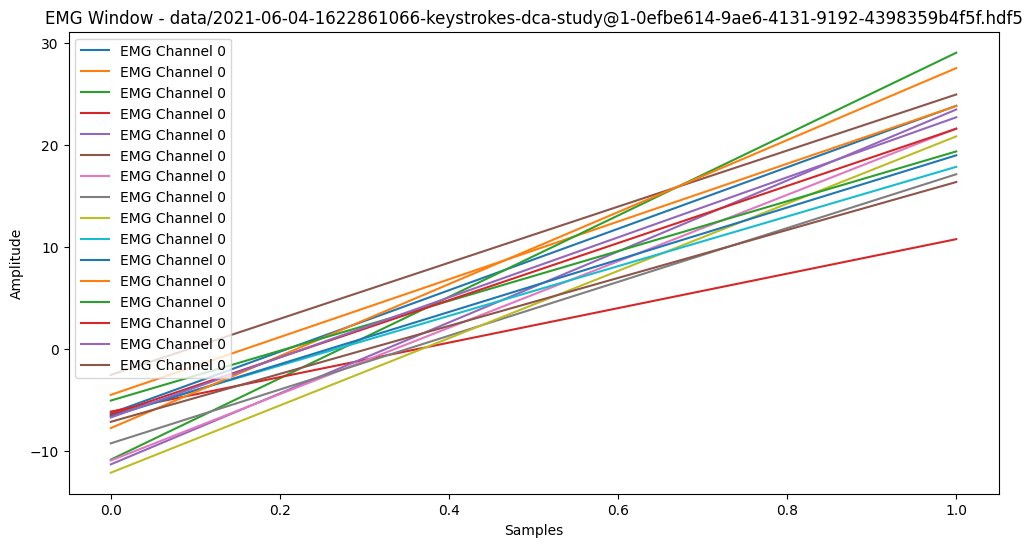

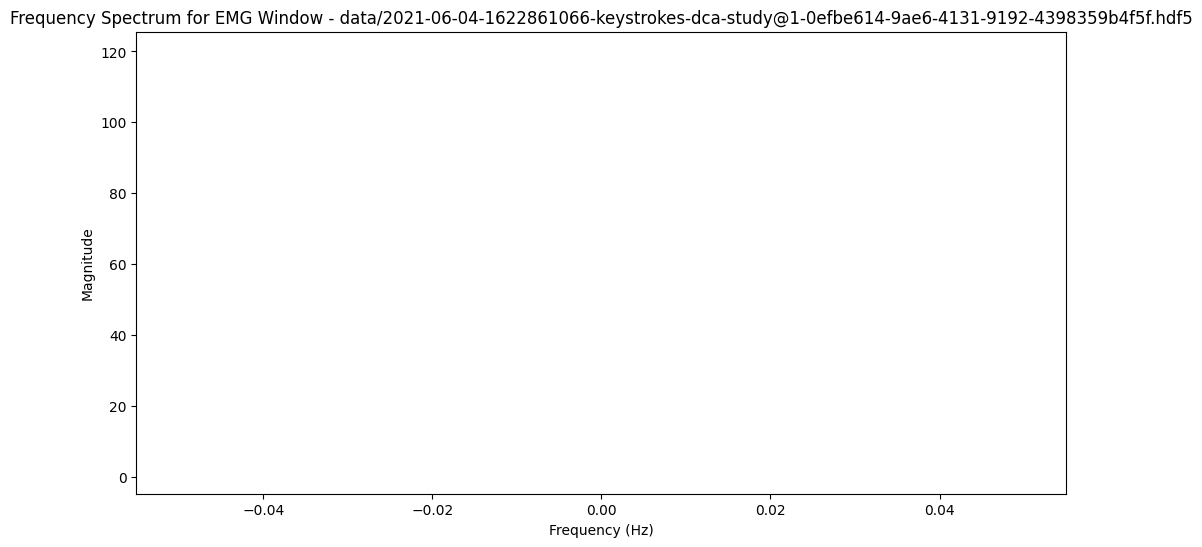

Keystrokes (Labels): [{'ascii': 116, 'key': 't', 'start': 1622861072.3208325, 'end': 1622861072.3938372}, {'ascii': 104, 'key': 'h', 'start': 1622861072.4088373, 'end': 1622861072.5438347}, {'ascii': 101, 'key': 'e', 'start': 1622861072.5288315, 'end': 1622861072.6338682}, {'ascii': 32, 'key': 'Key.space', 'start': 1622861072.648832, 'end': 1622861072.7538357}, {'ascii': 113, 'key': 'q', 'start': 1622861072.798831, 'end': 1622861072.9188347}, {'ascii': 117, 'key': 'u', 'start': 1622861072.9638336, 'end': 1622861073.158834}, {'ascii': 105, 'key': 'i', 'start': 1622861073.0688336, 'end': 1622861073.2038312}, {'ascii': 99, 'key': 'c', 'start': 1622861073.2338333, 'end': 1622861073.353831}, {'ascii': 32, 'key': 'Key.space', 'start': 1622861073.4138317, 'end': 1622861073.5788305}, {'ascii': 106, 'key': 'j', 'start': 1622861073.4588335, 'end': 1622861073.4888332}, {'ascii': 9003, 'key': 'Key.backspace', 'start': 1622861074.118868, 'end': 1622861074.1788344}, {'ascii': 9003, 'key': 'Key.backs

IndexError: index 0 is out of bounds for dimension 0 with size 0

In [12]:
for file_path in hdf5_files:
    print(f"Processing file: {file_path}")
    emg_session = EMGSessionData(file_path)
    timeseries = emg_session.timeseries
    keystrokes = emg_session.metadata[EMGSessionData.KEYSTROKES]
    windowed_data = WindowedEMGDataset(
        hdf5_path=file_path,
        window_length=8000,
        stride=None,
        padding=(0, 0),
        jitter=False,
        transform=ToTensor()
    )

    for window, labels in windowed_data:
        print(f"Window size: {window.shape} (Time steps, Channels)")
        print(f"Window Mean: {window.mean().item()}")
        print(f"Window Standard Deviation: {window.std().item()}")
        plt.figure(figsize=(12, 6))
        plt.plot(window[0].cpu().numpy(), label="EMG Channel 0")
        plt.legend()
        plt.title(f"EMG Window - {file_path}")
        plt.xlabel("Samples")
        plt.ylabel("Amplitude")
        plt.show()

        # Perform FFT for frequency content
        window_samples = window[0].cpu().numpy()
        fft_result = np.fft.fft(window_samples)
        frequencies = np.fft.fftfreq(len(fft_result), d=1/125)
        plt.figure(figsize=(12, 6))
        plt.plot(frequencies[:len(frequencies)//2], np.abs(fft_result)[:len(fft_result)//2])
        plt.title(f"Frequency Spectrum for EMG Window - {file_path}")
        plt.xlabel("Frequency (Hz)")
        plt.ylabel("Magnitude")
        plt.show()

        # Visualize labels
        print("Keystrokes (Labels):", keystrokes)
        print(f"Number of Labels: {len(labels)}")
        print(f"Label Sample: {labels[0]}")

        # Visualize left and right EMG channels
        emg_left = timeseries[EMGSessionData.EMG_LEFT]
        emg_right = timeseries[EMGSessionData.EMG_RIGHT]
        plt.figure(figsize=(12, 6))
        plt.plot(emg_left[:100, 0], label="Left EMG (Channel 0)")
        plt.plot(emg_right[:100, 0], label="Right EMG (Channel 0)")
        plt.legend()
        plt.title("EMG Data from Left and Right Wrists (First 100 Samples)")
        plt.xlabel("Samples")
        plt.ylabel("Amplitude")
        plt.show()



### 3.2. Normalization

Normalize the sEMG signals by channel.

In [1]:

all_data = []

for file_path in hdf5_files:
    print(f"Processing file: {file_path}")
    emg_session = EMGSessionData(file_path)
    timeseries = emg_session.timeseries

    # Collect data for mean and std computation
    all_data.append(timeseries)

# Concatenate all data and compute mean and std
all_data = np.concatenate(all_data, axis=0)
mean = all_data.mean()
std = all_data.std()

print(f"Computed Mean: {mean}")
print(f"Computed Std: {std}")

# Use the computed mean and std for normalization
normalize_transform = Normalize(mean=mean, std=std)

for file_path in hdf5_files:
    print(f"Processing file: {file_path}")
    emg_session = EMGSessionData(file_path)
    timeseries = emg_session.timeseries
    keystrokes = emg_session.metadata[EMGSessionData.KEYSTROKES]
    windowed_data = WindowedEMGDataset(
        hdf5_path=file_path,
        window_length=8000,
        stride=None,
        padding=(0, 0),
        jitter=False,
        transform=ToTensor()
    )

    for window, labels in windowed_data:
        # Normalize the window
        window = normalize_transform(window)

        print(f"Window size: {window.shape} (Time steps, Channels)")
        print(f"Window Mean: {window.mean().item()}")
        print(f"Window Standard Deviation: {window.std().item()}")
        plt.figure(figsize=(12, 6))
        plt.plot(window[0].cpu().numpy(), label="EMG Channel 0")
        plt.legend()
        plt.title(f"EMG Window - {file_path}")
        plt.xlabel("Samples")
        plt.ylabel("Amplitude")
        plt.show()

        # Perform FFT for frequency content
        window_samples = window[0].cpu().numpy()
        fft_result = np.fft.fft(window_samples)
        frequencies = np.fft.fftfreq(len(fft_result), d=1/125)
        plt.figure(figsize=(12, 6))
        plt.plot(frequencies[:len(frequencies)//2], np.abs(fft_result)[:len(fft_result)//2])
        plt.title(f"Frequency Spectrum for EMG Window - {file_path}")
        plt.xlabel("Frequency (Hz)")
        plt.ylabel("Magnitude")
        plt.yscale('log')  # Set y-axis to log scale
        plt.show()

        # Visualize labels
        print("Keystrokes (Labels):", keystrokes)
        print(f"Number of Labels: {len(labels)}")
        print(f"Label Sample: {labels[0]}")

        # Visualize left and right EMG channels
        emg_left = timeseries[EMGSessionData.EMG_LEFT]
        emg_right = timeseries[EMGSessionData.EMG_RIGHT]
        plt.figure(figsize=(12, 6))
        plt.plot(emg_left[:100, 0], label="Left EMG (Channel 0)")
        plt.plot(emg_right[:100, 0], label="Right EMG (Channel 0)")
        plt.legend()
        plt.title("EMG Data from Left and Right Wrists (First 100 Samples)")
        plt.xlabel("Samples")
        plt.ylabel("Amplitude")
        plt.show()

NameError: name 'hdf5_files' is not defined


## 4. Visualize the Raw and Processed sEMG Signals

Let's visualize the signals to ensure that the preprocessing is effective.

In [ ]:
# Visualize the raw and filtered sEMG signals from one of the channels
channel = 0  # Choose a channel to plot
time = np.arange(emg_data.shape[0]) / sampling_rate  # Time vector

plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(time, emg_data[:, channel])
plt.title('Raw sEMG Signal (Channel 0)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

plt.subplot(2, 1, 2)
plt.plot(time, filtered_emg_data[:, channel])
plt.title('Filtered sEMG Signal (Channel 0)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()


## 5. Extract Features (Optional)

You can extract additional features like RMS, zero-crossing rate, etc.

In [ ]:
# RMS Feature Extraction
def rms(data, window_size=100):
    return np.sqrt(np.mean(data**2, axis=0))

rms_features = rms(filtered_emg_data)

# Plot RMS features over time
plt.figure(figsize=(10, 5))
plt.plot(time[:len(rms_features)], rms_features)
plt.title('RMS of the Filtered sEMG Signal')
plt.xlabel('Time (s)')
plt.ylabel('RMS Amplitude')
plt.show()


## 6. Preparing the Data for Training

Since the input sEMG data and the ground-truth keystrokes may have different sequence lengths, we will need to prepare the data accordingly.

```python
# You can further split your data into training/validation sets, implement padding,
# and prepare the data for the CTC Loss function.

# Example of how to align data with CTC Loss:
# pad_sequences, encode the keystroke labels, and apply CTC loss preparation here.
```

